In [1]:
import netCDF4
from numpy import *
import matplotlib.pyplot as plt
import xarray as xr
# import PyNIO as Nio #deprecated
import pandas as pd
import glob
from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from area_mean import *
from scipy.optimize import curve_fit
import seaborn as sns
from copy import deepcopy
from useful_func_cy import *

In [2]:
# 12 cmip6 model: deck_nas = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM2', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0']

exp = 'piControl'
    
# CMIP6: 31 (30: BCCCSMCM2MR)
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCCSMCM2MR = {'modn': 'BCC-CSM2-MR', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CMCCCM2SR5 = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6', 
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCMFV2 = {'modn': 'CESM2-WACCM-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CNRMCM61 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM61HR = {'modn': 'CNRM-CM6-1-HR', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMESM21 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

ECEarth3 = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3Veg = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE22G = {'modn': 'GISS-E2-2-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
# HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
#             'exper': 'piControl', 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}   #..missing 'wap' in 'piControl' exp(Daniel says that HadGEM3-GC31 not using p-level, so doesn't have variables on p-level
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6', 
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MIROCES2L = {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NESM3 = {'modn': 'NESM3', 'consort': 'NUIST', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NorESM2MM = {'modn': 'NorESM2-MM', 'consort': 'NCC', 'cmip': 'cmip6',
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0 = {'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6', 
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
TaiESM1 = {'modn': 'TaiESM1', 'consort': 'AS-RCEC', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

# CMIP5: 20 (18, ACCESS10, ACCESS13)
ACCESS10 = {'modn': 'ACCESS1-0', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
ACCESS13 = {'modn': 'ACCESS1-3', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
BNUESM = {'modn': 'BNU-ESM', 'consort': 'BNU', 'cmip': 'cmip5',
          'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

CCSM4 = {'modn': 'CCSM4', 'consort': 'NCAR', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CNRMCM5 = {'modn': 'CNRM-CM5', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CSIRO_Mk360 = {'modn': 'CSIRO-Mk3-6-0', 'consort': 'CSIRO-QCCCE', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CanESM2 = {'modn': 'CanESM2', 'consort': 'CCCma', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSg2 = {'modn': 'FGOALS-g2', 'consort': 'LASG-CESS', 'cmip': 'cmip5',   # missing 'prw' in piControl
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSs2 = {'modn': 'FGOALS-s2', 'consort': 'LASG-IAP', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLCM3 = {'modn': 'GFDL-CM3', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2H = {'modn': 'GISS-E2-H', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2R = {'modn': 'GISS-E2-R', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
IPSLCM5ALR = {'modn': 'IPSL-CM5A-LR', 'consort': 'IPSL', 'cmip': 'cmip5',
               'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROC5 = {'modn': 'MIROC5', 'consort': 'MIROC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMMR = {'modn': 'MPI-ESM-MR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
NorESM1M = {'modn': 'NorESM1-M', 'consort': 'NCC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

MIROCESM = {'modn': 'MIROC-ESM', 'consort': 'MIROC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MRICGCM3 = {'modn': 'MRI-CGCM3', 'consort': 'MRI', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMLR = {'modn': 'MPI-ESM-LR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
bcccsm11 = {'modn': 'bcc-csm1-1', 'consort': 'BCC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2G = {'modn': 'GFDL-ESM2G', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2M = {'modn': 'GFDL-ESM2M', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

# cmip5 + cmip6
deck2 = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM21, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0, E3SM10, FGOALSg3, GFDLCM4, CAMSCSM1, INM_CM48, MPIESM12LR, AWICM11MR, CMCCCM2SR5, CESM2WACCMFV2, CNRMCM61, CNRMCM61HR, ECEarth3, ECEarth3Veg, GISSE22G, MIROCES2L, NESM3, NorESM2MM, TaiESM1, BNUESM, CCSM4, CNRMCM5, CSIRO_Mk360, CanESM2, FGOALSg2, FGOALSs2, GFDLCM3, GISSE2H, GISSE2R, IPSLCM5ALR, MIROC5, MPIESMMR, NorESM1M, MIROCESM, MRICGCM3, MPIESMLR, bcccsm11, GFDLESM2G, GFDLESM2M]  # current # 30 + 20 = 50
deck_nas2 = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM21', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0', 'E3SM10', 'FGOALSg3', 'GFDLCM4', 'CAMSCSM1', 'INM_CM48', 'MPIESM12LR', 'AWICM11MR', 'CMCCCM2SR5', 'CESM2WACCMFV2', 'CNRMCM61', 'CNRMCM61HR', 'ECEarth3', 'ECEarth3Veg', 'GISSE22G', 'MIROCES2L', 'NESM3', 'NorESM2MM', 'TaiESM1', 'BNUESM', 'CCSM4', 'CNRMCM5', 'CSIRO_Mk360', 'CanESM2', 'FGOALSg2', 'FGOALSs2', 'GFDLCM3', 'GISSE2H', 'GISSE2R', 'IPSLCM5ALR', 'MIROC5', 'MPIESMMR', 'NorESM1M', 'MIROCESM', 'MRICGCM3', 'MPIESMLR', 'bcccsm11', 'GFDLESM2G', 'GFDLESM2M']  # current # 30 + 20 = 50


In [3]:
deck3 = [CanESM5, E3SM10, CESM2FV2, CESM2, CNRMCM61, CESM2WACCMFV2, CNRMESM21, NESM3, IPSLCM6ALR, CESM2WACCM, MIROCESM, TaiESM1, ECEarth3Veg, CNRMCM61HR, ECEarth3, 
         FGOALSs2, IPSLCM5ALR, CSIRO_Mk360, BNUESM, GFDLCM3, GFDLCM4, SAM0, CanESM2, MPIESMLR, CMCCCM2SR5, MPIESMMR, FGOALSg2, BCCESM1, CNRMCM5, AWICM11MR, MRIESM20, 
          GISSE21H, MPIESM12LR, CCSM4, NorESM1M, FGOALSg3, bcccsm11, MIROC5, GISSE21G, MIROCES2L, MRICGCM3, MIROC6, NorESM2MM, GFDLESM2M, GFDLESM2G, GISSE22G, GISSE21H, CAMSCSM1, GISSE2R, INM_CM48]

deck3_nas = ['CanESM5', 'E3SM10', 'CESM2FV2', 'CESM2', 'CNRMCM61', 'CESM2WACCMFV2', 'CNRMESM21', 'NESM3', 'IPSLCM6ALR', 'CESM2WACCM', 'MIROCESM', 'TaiESM1', 'ECEarth3Veg', 'CNRMCM61HR', 'ECEarth3', 
         'FGOALSs2', 'IPSLCM5ALR', 'CSIRO_Mk360', 'BNUESM', 'GFDLCM3', 'GFDLCM4', 'SAM0', 'CanESM2', 'MPIESMLR', 'CMCCCM2SR5', 'MPIESMMR', 'FGOALSg2', 'BCCESM1', 'CNRMCM5', 'AWICM11MR', 'MRIESM20', 
          'GISSE21H', 'MPIESM12LR', 'CCSM4', 'NorESM1M', 'FGOALSg3', 'bcccsm11', 'MIROC5', 'GISSE21G', 'MIROCES2L', 'MRICGCM3', 'MIROC6', 'NorESM2MM', 'GFDLESM2M', 'GFDLESM2G', 'GISSE22G', 'GISSE21H', 'CAMSCSM1', 'GISSE2R', 'INM_CM48']

# Calculate 5*5 bin array for variables (LWP, CCFs) in Sounthern Ocean Region:
#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9

path1 = '/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/'
path6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/plot_file/'

In [4]:
## Read two Regimes (Warm, Cold) data

output_ARRAY = {}   # storage output file
output_intermedia = {}   # storage the 'rawdata_dict'

output_dict0_PI = {}
output_dict0_abr = {}

output_GMT = {}
output_2lrm_predict = {}  # dict, store annualy, area_meaned prediction of LWP
output_2lrm_report = {}  # dict, store annually, area_meaned actual values of GCMs LWP
output_2lrm_coef_LWP = {}
output_2lrm_dict_Albedo = {}  # Coefficients of 2 regimes's albedo trained by report 'LWP' data
# output_2lrm_coef_albedo_lL = {}

# Raw data
output_2lrm_yr_bin_abr = {}
output_2lrm_yr_bin_PI = {}
output_2lrm_mon_bin_abr = {}
output_2lrm_mon_bin_PI = {}

# Metric raw data in specific units:
shape_mon_pi = {}
shape_mon_abr = {}
output_2lrm_metric_actual_PI = {}
output_2lrm_metric_actual_abr = {}

# Statistic metrics of PI:
output_Mean_training = {}
output_Stdev_training = {}

# Predict metric data in specific units:
output_2lrm_mon_bin_LWPpredi_PI = {}
output_2lrm_mon_bin_LWPpredi_abr = {}

# Index for regime(s): Only for 2lrm
output_ind_Cold_PI = {}
output_ind_Hot_PI = {}
output_ind_Cold_abr = {}
output_ind_Hot_abr = {}

Tr_sst =  0.0

for i in range(len(deck2)):
    # print("i", i)
    # folder_2lrm = glob.glob(path1+deck2[i]['modn'] + '_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest' + '*' + '_dats.npz')
    folder_2lrm = glob.glob(path1+deck2[i]['modn'] + '__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest'+ '*' + '_dats.npz')
    # print(len(folder_2lrm))
    
    if len(folder_2lrm) == 4:
        if (len(folder_2lrm[0]) < len(folder_2lrm[1])) & (len(folder_2lrm[0]) < len(folder_2lrm[2])) & (len(folder_2lrm[0]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[0]
        elif (len(folder_2lrm[1]) < len(folder_2lrm[0])) & (len(folder_2lrm[1]) < len(folder_2lrm[2])) & (len(folder_2lrm[1]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[2]) < len(folder_2lrm[0])) & (len(folder_2lrm[2]) < len(folder_2lrm[1])) & (len(folder_2lrm[2]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[2]
        else:
            folder_best2lrm = folder_2lrm[3]
        print(folder_best2lrm)
    
    elif len(folder_2lrm) == 3:
        if (len(folder_2lrm[1]) <  len(folder_2lrm[0])) & (len(folder_2lrm[1]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[0]) <  len(folder_2lrm[1])) & (len(folder_2lrm[0]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[0]
        else:
            folder_best2lrm = folder_2lrm[2]
        print(folder_best2lrm)
    
    elif len(folder_2lrm) == 2:
        if len(folder_2lrm[1]) <  len(folder_2lrm[0]):
            folder_best2lrm = folder_2lrm[1]
        else:
            folder_best2lrm = folder_2lrm[0]
        print(folder_best2lrm)
        
    else:
        
        folder_best2lrm = folder_2lrm[0]
        print(folder_best2lrm)
    
    output_ARRAY[deck_nas2[i]] = load(folder_best2lrm, allow_pickle = True)  #+'_'+str(Tr_sst)
    
    output_intermedia[deck_nas2[i]] = output_ARRAY[deck_nas2[i]]['rawdata_dict']
    
    output_GMT[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['GMT']
    output_2lrm_predict[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['predicted_metrics']
    output_2lrm_report[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['report_metrics']

    output_dict0_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_abr_var']
    
    output_2lrm_coef_LWP[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Coef_dict']
    output_2lrm_dict_Albedo[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['coef_dict_Albedo_pi']
    
    # Monthly data
    output_2lrm_mon_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_mon_bin_PI']
    output_2lrm_mon_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_mon_bin_abr']
    # Annual data
    output_2lrm_yr_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_yr_bin_PI']
    output_2lrm_yr_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_yr_bin_abr']
    
    # Flattened Metric monthly mean bin data
    shape_mon_pi[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_PI_3']
    shape_mon_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_abr_3']
    output_2lrm_metric_actual_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_training']
    output_2lrm_metric_actual_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_predict']
    
    # Flattened Predicted monthly bin data
    output_2lrm_mon_bin_LWPpredi_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_PI']
    output_2lrm_mon_bin_LWPpredi_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_abr']

    # Statistic metrics of PI:
    output_Mean_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Mean_training']
    output_Stdev_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Stdev_training']
    
    # Indice for Regimes
    output_ind_Hot_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_PI']
    output_ind_Cold_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_PI']

    output_ind_Hot_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_abr']
    output_ind_Cold_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_abr']

print('Down read 2-LRM.')

/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/BCC-ESM1__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-3.63_dats.npz
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CanESM5__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-12.91_dats.npz
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest0.28_dats.npz
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-FV2__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-0.42_dats.npz
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-WACCM__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest0.35_dats.npz
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CNRM-ESM2-1__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-1.55_dats.npz
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/GISS-E2-1-G__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-4.57_dats.npz
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/GISS-E2

### Fig 7:
d(LWP)/ d(P-E) for GCM Cold aand Warm regimes and Observed d(LWP)/ d(P-E);
d(albedo)/ d(LWP) for GCMs and Observed d(albedo)/ d(LWP):

In [5]:
from scipy.optimize import curve_fit
def target_func(x, m, k):
    
    '''
    1-d line linear fit
    '''
    y = m*x + k
    return y


def calc_r2(Y_pre, Y):

    residual_ydata = array(Y).reshape(-1,1) - array(Y_pre).reshape(-1,1)
    
    ss_res_bar  = (residual_ydata**2).sum()
    ss_tot_bar  = ((Y - Y.mean())**2).sum()
    R_square = 1. - (ss_res_bar/ss_tot_bar)

    return R_square

In [6]:
# import numpy as np
from scipy.stats import *

# define the curve function which you intend to fit:
def target_func_poly1(x, a, b):
    
    '''
    linear fit
    '''
    y = a* x + b
    return y

def target_func_poly2(x, a, b, c):
    
    '''
    2d polynomial fit
    '''
    y = a* x**2 + b* x**1 + c
    return y


def target_func_power(x, a, b):
    '''
    POWER law fir
    '''
    
    y = a * x**b
    return y


def target_func_expo(x, a, b, c):

    '''
    exponential fitting
    '''
    y = a * b**x + c
    return y

In [7]:
# Standard deviation of Cloud Controlling factor (Xi) and Liquid Water Path (LWP):

sigmaXi_r1 = full((len(deck2), 4), 0.0)  # Cold
sigmaXi_r2 = full((len(deck2), 4), 0.0)  # Hot

sigmaalbedo_r1 = full((len(deck2)), 0.00) # Cold
sigmaalbedo_r2 = full((len(deck2)), 0.00) # Hot

sigmaLWP_r1 = full((len(deck2)), 0.0)  # Cold
sigmaLWP_r2 = full((len(deck2)), 0.0)  # Hot
sigmaLWP_ALL = full((len(deck2)), 0.0)  # Southern Ocean as a whole

sigmaalbedo_ALL = full((len(deck2)), 0.00) # Southern Ocean as a whole

In [8]:
for i in range(len(deck_nas2)):
    
    # indice of Regimes;
    ind_Cold_PI = output_ind_Cold_PI[deck_nas2[i]]
    ind_Hot_PI = output_ind_Hot_PI[deck_nas2[i]]
    ind_Cold_abr = output_ind_Cold_abr[deck_nas2[i]]
    ind_Hot_abr = output_ind_Hot_abr[deck_nas2[i]]
    # print(ind_Cold_PI.shape)
    # print(ind_Hot_abr)

    # print(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST'][ind_Hot_PI].shape)
    ## calc standard_deviation for CCFs at training period:

    sigmaXi_r1[i,:] = np.asarray([np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST'][ind_Cold_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e'][ind_Cold_PI]), 
                          np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS'][ind_Cold_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB'][ind_Cold_PI])])
    
    sigmaXi_r2[i,:] = np.asarray([np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST'][ind_Hot_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e'][ind_Hot_PI]), 
                          np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS'][ind_Hot_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB'][ind_Hot_PI])])
    
    sigmaLWP_r1[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP'][ind_Cold_PI])
    sigmaLWP_r2[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP'][ind_Hot_PI])
    sigmaalbedo_r1[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['albedo'][ind_Cold_PI])
    sigmaalbedo_r2[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['albedo'][ind_Hot_PI])
    sigmaLWP_ALL[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP'][logical_or(ind_Cold_PI, ind_Hot_PI)])
    sigmaalbedo_ALL[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['albedo'][logical_or(ind_Hot_PI, ind_Cold_PI)])

print(sigmaXi_r1.shape)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


(50, 4)


In [9]:
# Observation coefficient of LWP and CCFs.:

from calc_LRMobs_metric import *
from calc_Radiation_OBS_2 import *
from fitLRMobs import *
from Aploting_Sep11 import *

valid_range1=[2012, 1, 15]
valid_range2=[2016, 12, 31]
valid_range3=[2003, 1, 15]
valid_range4=[2012, 12, 31]

# OBS coef of LWP to CCFs:

# Function #1 loopping through variables space to find the cut-offs of LRM (Multi-Linear Regression Model).
dict_training, lats_Array, lons_Array, times_Array_training = Pre_processing(s_range, x_range, y_range, valid_range1 = valid_range1, valid_range2 = valid_range2)
dict_predict, lats_Array, lons_Array, times_Array_predict = Pre_processing(s_range, x_range, y_range, valid_range1 = valid_range3, valid_range2 = valid_range4)

# Loop_OBS_LRM(dict_training, dict_predict, s_range, x_range, y_range)

# Function #2 training LRM with using no cut-off, then use it to predict another historical period.

predict_result_1r = fitLRMobs_1(dict_training, dict_predict, s_range, y_range, x_range, lats_Array, lons_Array)
coef_obs = predict_result_1r['coef_dict']

# Prepare for calculating standardized coef:
std_dev_LWP_obs = predict_result_1r['std_LWP_training'] * 1000.
mean_state_LWP_obs = np.nanmean(area_mean(dict_training['LWP'], y_range, x_range)) * 1000.

print(std_dev_LWP_obs, mean_state_LWP_obs)
print(coef_obs[0])

sigmaXi_r2_obs = np.full((4), 0.0)
sigmaXi_r2_obs = np.asarray([np.nanstd(dict_training['SST']), np.nanstd(dict_training['p_e']), np.nanstd(dict_training['LTS']), np.nanstd(dict_training['SUB'])])
print(sigmaXi_r2_obs)

a = 1000. * coef_obs[0] * sigmaXi_r2_obs
print(a)

(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:147: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:147: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:148: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:148: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan


 ended cropping 
 ended cropping 


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/useful_func_cy.py:174: RuntimeWarning: Mean of empty slice
  annual_array[i,:,:] = nanmean(dict_rawdata[variable_nas[v]][i*12:(i+1)*12, :,:], axis = 0)


End monthly data binned.
End annually data binned.
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012]
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)
 ended cropping 
 ended cropping 
End monthly data binned.
End annually data binned.
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
predictors metrix shape:  (4, 38880)
shape1:  (38880,)
shape2:  (1, 20257)
 Total # of regime 1
(4, 77760)
shape1:  (77760,)
shape2:  (1, 40208)
 Total # of regime 1
current # of regimes 0
20.6066197596091 92.27586295018321
[ 3.15625283e-03  1.30671639e-02 -3.24761545e-05  1.37516961e-01]
[4.07733122 1.25271614 9.07331734 0.01926742]
[12.86908818 16.36944715 -0.29466646  2.64959652]


In [18]:
a = 1000. * coef_obs[0] * sigmaXi_r2_obs
print(a)

[12.86908818 16.36944715 -0.29466646  2.64959652]


training period choose: 1992 - 2016; coefficients are: [3.03541216e-03, 1.23134812e-02, 4.57475692e-06,  1.38984055e-01]


training period choose: 2003 - 2016; coefficients are: [3.07250924e-03, 1.29175350e-02, 8.59879960e-06,  1.54151055e-01]


training period choose: 2012 - 2016; coefficients are: [3.15625283e-03,  1.30671639e-02, -3.24761545e-05,  1.37516961e-01]


Training period choose: 1992 - 1996; coefficients are: [3.00341907e-03,  1.13070575e-02, -4.38717369e-06,  1.01124035e-01]

In [10]:
# Observational coef of albedo to LWP: 

valid_range1=[2003, 1, 15]
valid_range2=[2016, 12, 31]
valid_range3=[2003, 1, 15]
valid_range4=[2012, 12, 31]

coef_dict_Alpha_cre_training, coef_dict_Albedo_training, coef_dict_Albedo_bin_training, dict_Alpha_cre_predict, coef_dict_Albedo_predict, coef_dict_Albedo_bin_predict = calc_Radiation_OBS_2(s_range, x_range, y_range, valid_range1 = valid_range1, valid_range2 = valid_range2, valid_range3 = valid_range3, valid_range4 = valid_range4)

print(coef_dict_Albedo_training)
# coef_Albedo_obs = coef_dict_Albedo_training['15.0']

(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012]
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:73: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:73: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:74: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:74: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cl

 ended cropping 


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:112: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:113: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:113: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:115: RuntimeWarning: invalid value encountered in less_equal
  LWP_predict[LWP_predict <= 0.0] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OB

 ended cropping 
the first month in training and predict data:  1.0 1.0
threshold =  0.11
 fration of not NaN points to All points in OBS training data: 0.213994708994709


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 model_binLWP, albedo_bin = a1 * lwp_bin + a2 * albedo_cs_bin + a3:                              OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3472.
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           2.64e-17
Time:                        15:11:59   Log-Likelihood:                 68.478
No. Observations:                  15   AIC:                            -131.0
Df Residuals:                      12   BIC:                            -128.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 model_binLWP, albedo_bin = a1 * lwp_bin + a2 * albedo_cs_bin + a3:                              OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     827.1
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           1.40e-13
Time:                        15:11:59   Log-Likelihood:                 56.762
No. Observations:                  15   AIC:                            -107.5
Df Residuals:                      12   BIC:                            -105.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1514.
Date:                Thu, 08 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:12:00   Log-Likelihood:             1.9564e+05
No. Observations:              129840   AIC:                        -3.913e+05
Df Residuals:                  129838   BIC:                        -3.912e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1845.
Date:                Thu, 08 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:12:00   Log-Likelihood:             1.9889e+05
No. Observations:              131870   AIC:                        -3.978e+05
Df Residuals:                  131868   BIC:                        -3.977e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1933.
Date:                Thu, 08 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:12:01   Log-Likelihood:             1.9855e+05
No. Observations:              132027   AIC:                        -3.971e+05
Df Residuals:                  132025   BIC:                        -3.971e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 model_binLWP, albedo_bin = a1 * lwp_bin + a2 * albedo_cs_bin + a3:                              OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     948.3
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           6.18e-14
Time:                        15:12:01   Log-Likelihood:                 58.405
No. Observations:                  15   AIC:                            -110.8
Df Residuals:                      12   BIC:                            -108.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 model_binLWP, albedo_bin = a1 * lwp_bin + a2 * albedo_cs_bin + a3:                              OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     78.78
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           1.26e-07
Time:                        15:12:01   Log-Likelihood:                 41.605
No. Observations:                  15   AIC:                            -77.21
Df Residuals:                      12   BIC:                            -75.09
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1157.
Date:                Thu, 08 Jun 2023   Prob (F-statistic):          4.48e-252
Time:                        15:12:01   Log-Likelihood:             1.4134e+05
No. Observations:               93942   AIC:                        -2.827e+05
Df Residuals:                   93940   BIC:                        -2.827e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     14.32
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           0.000663
Time:                        15:12:02   Log-Likelihood:                 32.387
No. Observations:                  15   AIC:                            -58.77
Df Residuals:                      12   BIC:                            -56.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1486      0.184     -0.807      0.4

In [11]:
coef_Albedo_obs = np.asarray([coef_dict_Albedo_training['15.0'], coef_dict_Albedo_training['30.0'], coef_dict_Albedo_training['11.0']])
print(coef_Albedo_obs)

[[ 0.48061433  4.68177674 -0.19347756]
 [ 0.41917498  1.96337457  0.11792966]
 [ 0.84822316  5.53735751 -0.32250854]]


In [12]:
N = 50

stcoef_albedo = np.zeros((N, 5))

stcoef_sst11 = []
stcoef_sst12 = []

stcoef_qcon11 = []
stcoef_qcon12 = []

stcoef_stabil11 = []
stcoef_stabil12 = []

stcoef_sub50011 = []
stcoef_sub50012 = []

# print(output_2lrm_coef_LWP[deck_nas2[9]])

for i in arange(len(deck_nas2)):

    stcoef_albedo[i,:] = (output_2lrm_dict_Albedo[deck_nas2[i]]['11.0'][0], output_2lrm_dict_Albedo[deck_nas2[i]]['12.0'][0], output_2lrm_dict_Albedo[deck_nas2[i]]['15.0'][0], output_2lrm_dict_Albedo[deck_nas2[i]]['20.0'][0], output_2lrm_dict_Albedo[deck_nas2[i]]['30.0'][0])

    stcoef_sst11.append(output_2lrm_coef_LWP[deck_nas2[i]][0][0][0])
    stcoef_sst12.append(output_2lrm_coef_LWP[deck_nas2[i]][1][0][0]) 

    stcoef_qcon11.append(output_2lrm_coef_LWP[deck_nas2[i]][0][0][1])
    stcoef_qcon12.append(output_2lrm_coef_LWP[deck_nas2[i]][1][0][1])

    stcoef_stabil11.append(output_2lrm_coef_LWP[deck_nas2[i]][0][0][2])
    stcoef_stabil12.append(output_2lrm_coef_LWP[deck_nas2[i]][1][0][2])

    stcoef_sub50011.append(output_2lrm_coef_LWP[deck_nas2[i]][0][0][3])
    stcoef_sub50012.append(output_2lrm_coef_LWP[deck_nas2[i]][1][0][3])
    
stcoef_albedo = asarray(stcoef_albedo)/ 1000. #  * sigmaLWP_ALL
Coef_albedo_lwp = stcoef_albedo * 100.
print(Coef_albedo_lwp)

stcoef_sst11 = asarray(stcoef_sst11) * 1000. * sigmaXi_r1[:,0]
stcoef_sst12 = asarray(stcoef_sst12) * 1000. * sigmaXi_r2[:,0]

stcoef_qcon11 = asarray(stcoef_qcon11) * 1000. * sigmaXi_r1[:,1]
stcoef_qcon12 = asarray(stcoef_qcon12) * 1000. * sigmaXi_r2[:,1]
print(stcoef_qcon12)

stcoef_stabil11 = asarray(stcoef_stabil11) * 1000. * sigmaXi_r1[:,2]
stcoef_stabil12 = asarray(stcoef_stabil12) * 1000. * sigmaXi_r2[:,2]

stcoef_sub50011 = asarray(stcoef_sub50011) * 1000. * sigmaXi_r1[:,3]
stcoef_sub50012 = asarray(stcoef_sub50012) * 1000. * sigmaXi_r2[:,3]

# d1 = {'col1': arange(0, 50), 'value': stcoef_albedo1.ravel(), 'Regimes': array(['All REGIME avg']*50)}
# data1  = pd.DataFrame(data=d1, index=arange(0, 50*1))

# print(asarray([stcoef2, stcoef1]).reshape(2, 30))


print(np.max(Coef_albedo_lwp), np.min(Coef_albedo_lwp))

[[0.10301418 0.10393557 0.10867852 0.11492167 0.12010213]
 [0.16407535 0.17542643 0.18988493 0.20662954 0.19088287]
 [0.13673591 0.13324381 0.14192807 0.1442777  0.14228943]
 [0.13865259 0.13704553 0.14699885 0.15065591 0.15124234]
 [0.13377469 0.13093412 0.14081824 0.1436488  0.14199456]
 [0.18345973 0.16869612 0.20546834 0.20569831 0.19016752]
 [0.03635622 0.03310085 0.03121641 0.03038672 0.04163078]
 [0.03877206 0.03647212 0.03302035 0.03086841 0.04495635]
 [0.0739658  0.06085053 0.06660084 0.06035599 0.04966391]
 [0.11057404 0.10875393 0.11977025 0.1244562  0.11517269]
 [0.05762028 0.0613413  0.08147428 0.08058771 0.07486478]
 [0.19046922 0.17920585 0.22786032 0.24096843 0.23272156]
 [0.21106385 0.20715054 0.21532389 0.22029221 0.22075974]
 [0.12584966 0.12817204 0.13280376 0.14722588 0.15620345]
 [0.15936815 0.15135438 0.16816465 0.1632675  0.13704609]
 [0.14815741 0.13997035 0.17044673 0.17778697 0.17745496]
 [0.36534459 0.39072571 0.27685667 0.29019513 0.28987921]
 [0.13516385 0

In [17]:
# Calc the mean_state_LWP v.s partial_alpha / partial_LWP & dLWP/ dP-E: 

N = 50
mean_Cold_albedo = []
mean_Warm_albedo = []
mean_Cold_LWP = []
mean_Warm_LWP = []
mean_state_albedo = []
mean_state_LWP = []
mean_state_sst = []
mean_state_P_E = []
mean_state_lts = []
mean_state_sub500 = []

layover_Cold_PI = {}
layover_Warm_PI = {}

rd_Cold = {}
rd_Warm = {}

mean_Cold_sst = []
mean_Warm_sst = []
Coef_LWP_sst = []

mean_Cold_p_e = []
mean_Warm_p_e = []
Coef_LWP_p_e = []

mean_Cold_lts = []
mean_Warm_lts = []
Coef_LWP_lts = []

mean_Cold_sub = []
mean_Warm_sub = []
Coef_LWP_sub = []

# area mean:
x_range = arange(-180., 180., 5.)   #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5   #..southern-ocaen latitude edge: 9

# calc values:
variables_nas = ['albedo', 'LWP', 'SST', 'p_e', 'LTS', 'SUB']
for i in range(len(deck2)):
    # Save into regime-dependent mean_state LWP AREA_MEAN VALUES
    shape_of_3dPImd = shape_mon_pi[deck_nas2[i]]

    for k in range(len(variables_nas)):
        layover_Warm_PI[variables_nas[k]] = output_2lrm_metric_actual_PI[deck_nas2[i]][variables_nas[k]] * 1.
        layover_Cold_PI[variables_nas[k]] = output_2lrm_metric_actual_PI[deck_nas2[i]][variables_nas[k]] * 1.
        
        layover_Warm_PI[variables_nas[k]][logical_not(output_ind_Hot_PI[deck_nas2[i]])] = nan
        layover_Cold_PI[variables_nas[k]][logical_not(output_ind_Cold_PI[deck_nas2[i]])] = nan
        
        rd_Cold[variables_nas[k]] = layover_Cold_PI[variables_nas[k]].reshape(shape_of_3dPImd)
        rd_Warm[variables_nas[k]] = layover_Warm_PI[variables_nas[k]].reshape(shape_of_3dPImd)
        
    # Save mean_state VARIABLES
    mean_state_albedo = nanmean(area_mean(output_2lrm_mon_bin_PI[deck_nas2[i]]['albedo_mon_bin'], y_range, x_range))
    mean_Cold_albedo.append(nanmean(area_mean(rd_Cold['albedo'], y_range, x_range)) + mean_state_albedo)
    mean_Warm_albedo.append(nanmean(area_mean(rd_Warm['albedo'], y_range, x_range)) + mean_state_albedo)
    
    mean_state_LWP.append(nanmean(area_mean(output_2lrm_mon_bin_PI[deck_nas2[i]]['LWP_mon_bin'], y_range, x_range)))
    Mean_state_lwp = nanmean(area_mean(output_2lrm_mon_bin_PI[deck_nas2[i]]['LWP_mon_bin'], y_range, x_range))
    mean_Cold_LWP.append(nanmean(area_mean(rd_Cold['LWP'], y_range, x_range)) + Mean_state_lwp)
    mean_Warm_LWP.append(nanmean(area_mean(rd_Warm['LWP'], y_range, x_range)) + Mean_state_lwp)
    
    mean_state_sst = nanmean(area_mean(output_2lrm_mon_bin_PI[deck_nas2[i]]['SST_mon_bin'], y_range, x_range))
    mean_Cold_sst.append(nanmean(area_mean(rd_Cold['SST'], y_range, x_range)) + mean_state_sst)
    mean_Warm_sst.append(nanmean(area_mean(rd_Warm['SST'], y_range, x_range)) + mean_state_sst)
    
    mean_state_P_E = nanmean(area_mean(output_2lrm_mon_bin_PI[deck_nas2[i]]['p_e_mon_bin'], y_range, x_range))
    mean_Cold_p_e.append(nanmean(area_mean(rd_Cold['p_e'], y_range, x_range)) + mean_state_P_E)
    mean_Warm_p_e.append(nanmean(area_mean(rd_Warm['p_e'], y_range, x_range)) + mean_state_P_E)
    
    mean_state_lts = nanmean(area_mean(output_2lrm_mon_bin_PI[deck_nas2[i]]['LTS_mon_bin'], y_range, x_range))
    mean_Cold_lts.append(nanmean(area_mean(rd_Cold['LTS'], y_range, x_range)) + mean_state_lts)
    mean_Warm_lts.append(nanmean(area_mean(rd_Warm['LTS'], y_range, x_range)) + mean_state_lts)
    
    mean_state_sub500 = nanmean(area_mean(output_2lrm_mon_bin_PI[deck_nas2[i]]['SUB_mon_bin'], y_range, x_range))
    mean_Cold_sub.append(nanmean(area_mean(rd_Cold['SUB'], y_range, x_range)) + mean_state_sub500)
    mean_Warm_sub.append(nanmean(area_mean(rd_Warm['SUB'], y_range, x_range)) + mean_state_sub500)
    
    # Save Coef(s):
    Coef_LWP_sst.append([stcoef_sst11[i], stcoef_sst12[i]])
    Coef_LWP_p_e.append([stcoef_qcon11[i], stcoef_qcon12[i]])
    Coef_LWP_lts.append([stcoef_stabil11[i], stcoef_stabil12[i]])
    Coef_LWP_sub.append([stcoef_sub50011[i], stcoef_sub50012[i]])

mean_state_LWP = 1000.* asarray(mean_state_LWP)
mean_Cold_LWP = 1000.* asarray(mean_Cold_LWP)
mean_Warm_LWP = 1000.* asarray(mean_Warm_LWP)

mean_Cold_albedo = 100.* asarray(mean_Cold_albedo)
mean_Warm_albedo = 100.* asarray(mean_Warm_albedo)

Coef_LWP_sst = asarray(Coef_LWP_sst).reshape(N, 2)
Coef_LWP_p_e = asarray(Coef_LWP_p_e).reshape(N, 2)
Coef_LWP_lts = asarray(Coef_LWP_lts).reshape(N, 2)
Coef_LWP_sub = asarray(Coef_LWP_sub).reshape(N, 2)
# print(mean_hotdown_p_e)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


[12.86908818 16.36944715 -0.29466646  2.64959652]


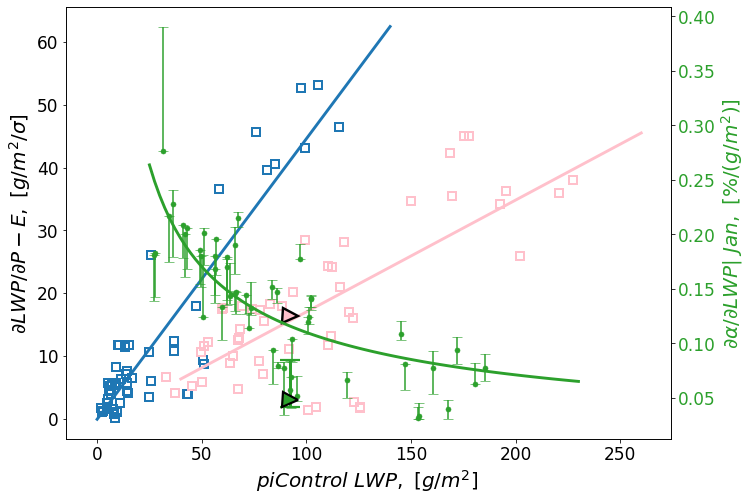

In [21]:
# Number of models currently

# plot settings:
parameters = {'axes.labelsize': 20, 'legend.fontsize': 18,
       'axes.titlesize': 21, 'xtick.labelsize': 17, 'ytick.labelsize': 17}
plt.rcParams.update(parameters)

fig3 = plt.figure(figsize=(12, 6))
ax33 = fig3.add_axes([0,0,0.7,1])

# GCM's dLWP_dP-E :
# Cold:
ax33.plot(mean_Cold_LWP, Coef_LWP_p_e[:,0], marker = 's', markersize = 8, c = 'tab:blue', fillstyle = 'none', markeredgewidth = 2., linestyle = 'None', zorder = 2)

# Warm:
ax33.plot(mean_Warm_LWP, Coef_LWP_p_e[:,1], marker = 's', markersize = 8, c = 'pink', fillstyle = 'none', markeredgewidth = 2., linestyle = 'None', zorder = 3)

ax33.set_xlabel(r"$ piControl\ LWP,\ [g/ m^{2}] $ ")

# disable the left y-axis for making animation purpose
# ax33.get_yaxis().set_ticks([])
ax33.set_ylabel(r"$ {\partial LWP}/{\partial {P - E}},\ [g/m^{2}/ \sigma] $", c = 'k')  #  g/m^{2}/ (mm/day)

# Second Y-axis:
ax34 = ax33.twinx()
# Observations' dLWP_dP-E:
print(a)
ax33.plot(mean_state_LWP_obs, a[1], marker = '>', color = 'pink', markersize = 15.0, markeredgecolor = 'black', markeredgewidth = 2.4, linestyle = 'None', zorder = 98)  # 1000.* asarray(coef_obs[0][1])
# print(asarray(coef_obs[0][1]))


# Observations' dalpha_dLWP:
yerror_min = (coef_Albedo_obs[0,0] - coef_Albedo_obs[1,0]) * 100. / 1000.
yerror_max = (coef_Albedo_obs[2,0] - coef_Albedo_obs[0,0]) * 100. / 1000.
yerror = np.array([yerror_min, yerror_max]).reshape(2,1)

ax34.errorbar(x= mean_state_LWP_obs, y = (100. / 1000. * asarray(coef_Albedo_obs[0,0])), yerr = yerror,
               color = 'tab:green', markersize = 15.0, marker = '>', markeredgecolor = 'k', markeredgewidth = 2.2, capsize = 10, linestyle = 'None', elinewidth = 3, zorder = 99)

# GCM's dalpha_dLWP: 
# One regime radiative efficiencies: 
color = 'tab:green'
yerror_gcm_min = np.zeros(len(deck2))
yerror_gcm_max = np.zeros(len(deck2))

for i in range(len(deck_nas2)):
    
    yerror_gcm_min[i] = (Coef_albedo_lwp[i, 2] - min(Coef_albedo_lwp[i, :]))
    yerror_gcm_max[i] = (max(Coef_albedo_lwp[i, :]) - Coef_albedo_lwp[i, 2])
yerror_gcm = np.array([yerror_gcm_min, yerror_gcm_max]).reshape(2, len(deck2))

ax34.errorbar(x = mean_state_LWP, y = Coef_albedo_lwp[:, 2], yerr = yerror_gcm, 
              color = 'tab:green', markersize = 5, marker = 'o', markeredgecolor = 'tab:green', markeredgewidth = 0.6, capsize = 5, linestyle = 'None', zorder = 1)
ax34.tick_params(axis='y', labelcolor=color)
ax34.set_ylabel(r"$ {\partial \alpha}/{\partial LWP}|\ {Jan},\ [\%/ (g/ m^{2})] $", color=color)  # we already handled the x-label with ax1  #  \ std.dev^{-1}(LWP)


# # Best Fit lines:

# dLWP_dP-E:
POPT_ccf_Cold, POCV_ccf_Cold = curve_fit(target_func_poly1, mean_Cold_LWP, Coef_LWP_p_e[:,0])
POPT_ccf_Warm, POCV_ccf_Hot = curve_fit(target_func_poly1, mean_Warm_LWP, Coef_LWP_p_e[:,1])

# dalpha_dLWP:
POPT_alphalwp, POCV_alphalwp = curve_fit(target_func_power, mean_state_LWP, Coef_albedo_lwp[:, 2])  # Use albedo_clear-sky <= 0.15 as the fitting point

# Plot the fit lines:

x1 = linspace(-0., 140., 90)
x2 = linspace(40., 260., 90)
x = linspace(25., 230., 85)
fitp1 = ax33.plot(x1, POPT_ccf_Cold[0] * x1 + POPT_ccf_Cold[1], c = 'tab:blue', linestyle = '-', linewidth = 2.9, label = ' Cold')
fitp2 = ax33.plot(x2, POPT_ccf_Warm[0] * x2 + POPT_ccf_Warm[1], c = 'pink', linestyle = '-', linewidth = 2.9, label = ' Warm')
plt.xlim([-15., 274.])

# plt.legend()
fitalpha1 = ax34.plot(x, POPT_alphalwp[0] * x ** POPT_alphalwp[1], c = 'tab:green', linestyle = '-', linewidth = 2.9, label = r'$ \partial \alpha / \partial LWP$')

# plt.legend()
# plt.title(r"$ \frac{\partial LWP}{\partial P\ -\ E}\ (left),$" + r"$\ \frac{\partial \alpha}{\partial LWP}\ (right)\ v.s\ mean\ state\ LWP $", pad = 14)


# plt.savefig(path6 + "Fig_7_(stddev).jpg", bbox_inches = 'tight', dpi = 500)